<a href="https://colab.research.google.com/github/FelixMaturano/SIS420-2025/blob/main/Parte2_modif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> # 📦 Dataset: CIFAR-10

El notebook trabaja con el dataset **CIFAR-10**, un subconjunto etiquetado de 80 millones de imágenes pequeñas creado por Alex Krizhevsky, Vinod Nair y Geoffrey Hinton.

- **Tamaño total**: 60 000 imágenes a color de 32×32 px  
- **Clases**: 10 categorías mutuamente excluyentes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck)  
- **Distribución**:  
  - 50 000 imágenes de entrenamiento (5 000 por clase, repartidas en 5 lotes aleatorios de 10 000)  
  - 10 000 imágenes de test (1 000 imágenes por clase)  

> “Automobile” incluye sedanes, SUVs, etc.; “Truck” sólo camiones grandes (no hay solapamiento).

---

# 🎯 Objetivos del cuadernillo

1. **Cargar y preprocesar** las imágenes de CIFAR-10 para que encajen en un modelo preentrenado (ResNet-18).  
2. **Extraer embeddings** (representaciones intermedias) de cada imagen usando ResNet-18.  
3. **Aplicar clustering** no supervisado (K-Means) sobre esos embeddings para agrupar imágenes por similitud.  
4. **Evaluar** la calidad del clustering con el índice de silueta.  
5. **Reducir dimensión** con PCA (opcional, para visualización y/o aceleración).  
6. **Entrenar un clasificador** supervisado (regresión logística) sobre los embeddings obtenidos y medir su desempeño.





In [1]:
import numpy as np
import pandas as pd
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, accuracy_score
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

# Verificar si la GPU está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


### 🔄 Preprocesamiento y carga

- **Transformaciones**: resize a 224×224, tensor, normalización ImageNet.  
- **Dataset**: CIFAR-10 (50 000 train, 10 000 test) con estas transformaciones.  
- **DataLoaders**: batches de 64 sin shuffle (solo extracción de embeddings).


In [2]:
# Transformaciones para las imágenes (compatible con ResNet18)
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Cargar CIFAR-10 (entrenamiento y prueba)
dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = CIFAR10(root='./data', train=False, transform=transform, download=True)

# DataLoaders
loader = DataLoader(dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


### ⚙️ Extracción de embeddings (train)

Configura ResNet-18 sin su capa final, extrae embeddings de cada batch y los guarda junto a sus etiquetas en un CSV.


In [3]:
# Modelo ResNet18
model = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model = model.to(device)
model.eval()

# Extraer características (entrenamiento)
features, labels = [], []
with torch.no_grad():
    for imgs, lbls in loader:
        imgs = imgs.to(device)
        out = model(imgs)
        out = out.view(out.size(0), -1)
        features.append(out.cpu().numpy())
        labels.append(lbls.numpy())

X = np.concatenate(features, axis=0)
y = np.concatenate(labels, axis=0).reshape(-1, 1)
data = np.hstack((X, y))
df = pd.DataFrame(data)
df.to_csv("cifar10_resnet18_features_train.csv", index=False)
print(" Características extraídas (entrenamiento)")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 204MB/s]


 Características extraídas (entrenamiento)


### 🧪 Extracción de embeddings (test)

Aplicamos el modelo ResNet-18 sobre las imágenes de prueba para extraer sus vectores de características y guardarlos junto a sus etiquetas en un archivo CSV.


In [4]:
# Extraer características (prueba)
test_features, test_labels = [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        out = model(imgs)
        out = out.view(out.size(0), -1)
        test_features.append(out.cpu().numpy())
        test_labels.append(lbls.numpy())

X_test = np.concatenate(test_features, axis=0)
y_test = np.concatenate(test_labels, axis=0).reshape(-1, 1)
data_test = np.hstack((X_test, y_test))
df_test = pd.DataFrame(data_test)
df_test.to_csv("cifar10_resnet18_features_test.csv", index=False)
print("Características extraídas (prueba)")

Características extraídas (prueba)


###  Carga de datos, normalización y reducción de dimensión (PCA)

Leemos las características extraídas desde archivos CSV, normalizamos los datos con `StandardScaler` y reducimos la dimensionalidad usando PCA para conservar el 95% de la varianza.


In [5]:
# Cargar CSVs
train_df = pd.read_csv('cifar10_resnet18_features_train.csv')
test_df = pd.read_csv('cifar10_resnet18_features_test.csv')

# Separar características y etiquetas
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values
X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

# Escalar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Dimensiones después de PCA: {X_train_pca.shape}, {X_test_pca.shape}")

Dimensiones después de PCA: (50000, 283), (10000, 283)


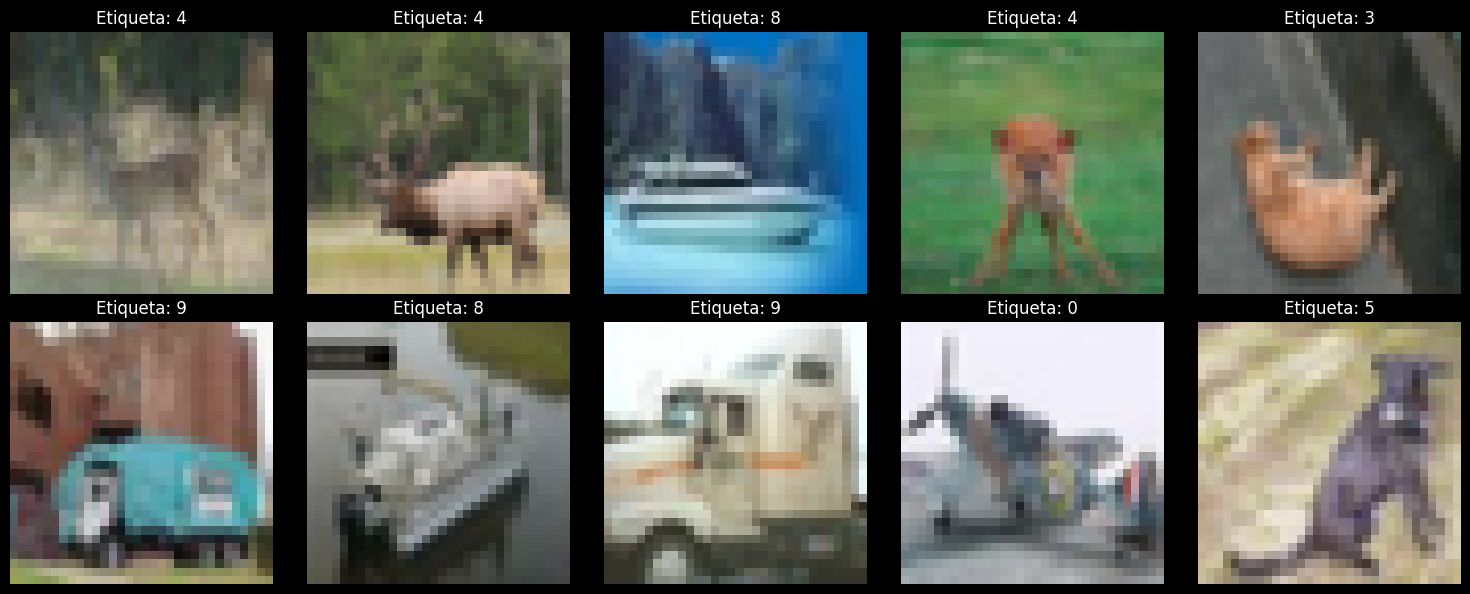

In [6]:
# Cargar el dataset CIFAR-10 para visualización sin transformaciones agresivas
cifar_data = CIFAR10(
    root='./data',
    train=True,
    transform=transforms.ToTensor(),
    download=False
)

# Seleccionar 10 índices aleatorios
indices = random.sample(range(len(X_train)), 10)

# Crear lienzo negro y figura de 2 filas x 5 columnas
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.patch.set_facecolor('black')  # Fondo negro para el lienzo

# Mostrar las imágenes
for i, idx in enumerate(indices):
    img, _ = cifar_data[idx]
    img = img.permute(1, 2, 0).numpy()  # Convertir a formato [H, W, C]
    label = int(y_train[idx])          # Obtener la etiqueta numérica

    row, col = divmod(i, 5)            # Calcular la posición en 2x5
    ax = axes[row, col]
    ax.imshow(img)
    ax.set_title(f"Etiqueta: {label}", color='white')  # Etiqueta con texto blanco
    ax.axis('off')                     # Ocultar ejes
    ax.set_facecolor('black')         # Fondo negro para cada subgráfico

plt.tight_layout()
plt.show()


<ipython-input-7-074373446253>:25: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


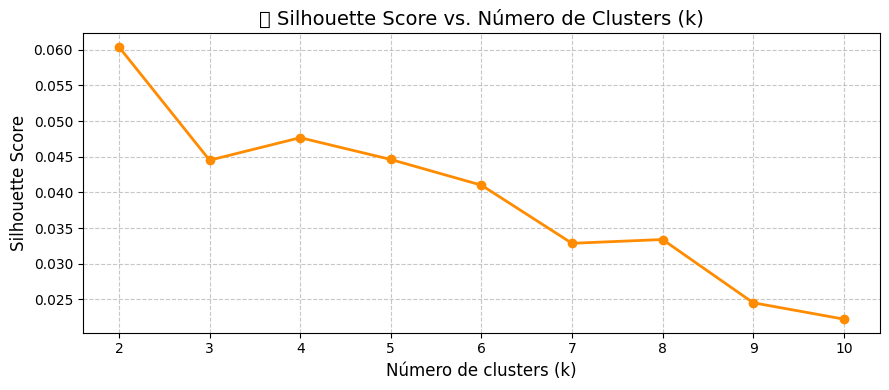

<ipython-input-7-074373446253>:36: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


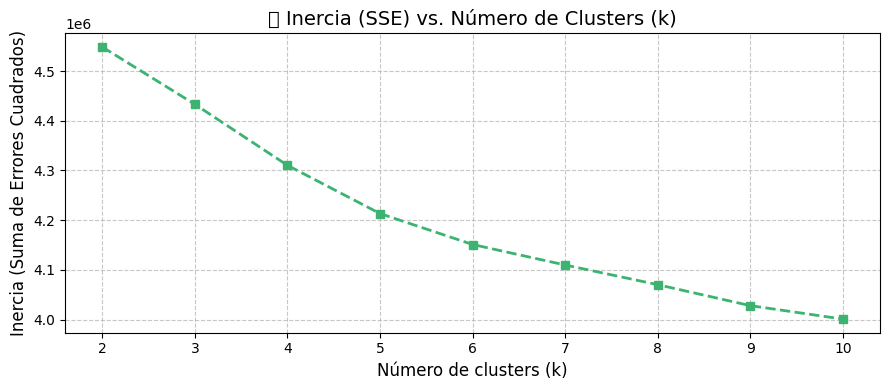

In [7]:
from matplotlib import cm

# 🔹 Selección de subconjunto de 10,000 muestras para análisis rápido
subset_size = 10000
X_subset = X_train_pca[:subset_size]

# 🔹 Inicializar métricas
inertia = []
silhouette_scores = []

# 🔹 Probar distintos valores de k para K-Means
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_subset)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_subset, kmeans.labels_))

# 🔸 Graficar puntuaciones de Silhouette
plt.figure(figsize=(9, 4))
plt.plot(range(2, 11), silhouette_scores, color='darkorange', marker='o', linestyle='-', linewidth=2)
plt.title("📈 Silhouette Score vs. Número de Clusters (k)", fontsize=14)
plt.xlabel("Número de clusters (k)", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)
plt.xticks(range(2, 11))
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 🔸 Graficar Inercia (Método del Codo)
plt.figure(figsize=(9, 4))
plt.plot(range(2, 11), inertia, color='mediumseagreen', marker='s', linestyle='--', linewidth=2)
plt.title("📉 Inercia (SSE) vs. Número de Clusters (k)", fontsize=14)
plt.xlabel("Número de clusters (k)", fontsize=12)
plt.ylabel("Inercia (Suma de Errores Cuadrados)", fontsize=12)
plt.xticks(range(2, 11))
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Entrenamiento y evaluación con Regresión Logística
En esta sección se entrena un modelo de regresión logística multiclase usando las características extraídas con PCA y se evalúa su precisión en el conjunto de prueba.

In [8]:
# Entrenar regresión logística
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
start = time.time()
log_reg.fit(X_train_pca, y_train)
end = time.time()
print(f"Tiempo de entrenamiento (regresión logística): {end - start:.2f} segundos")

# Evaluar precisión
accuracy = log_reg.score(X_test_pca, y_test)
print(f"Precisión regresión logística (etiquetas reales): {accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Tiempo de entrenamiento (regresión logística): 17.36 segundos
Precisión regresión logística (etiquetas reales): 0.8665


Aplicamos K-Means para identificar k imágenes representativas del conjunto y propagar sus etiquetas al resto de los datos.

In [9]:
# Definir k
k = 10

# Entrenar K-Means
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train_pca)

# Seleccionar imágenes representativas
idxs = np.argmin(X_digits_dist, axis=0)
y_representative_digits = y_train[idxs]  # Simular etiquetado manual

# Propagar etiquetas
y_train_propagated = y_representative_digits[kmeans.labels_]

# Evaluar precisión de etiquetas propagadas
accuracy_propagated = accuracy_score(y_train, y_train_propagated)
print(f"Precisión etiquetas propagadas (entrenamiento): {accuracy_propagated:.4f}")

Precisión etiquetas propagadas (entrenamiento): 0.6836


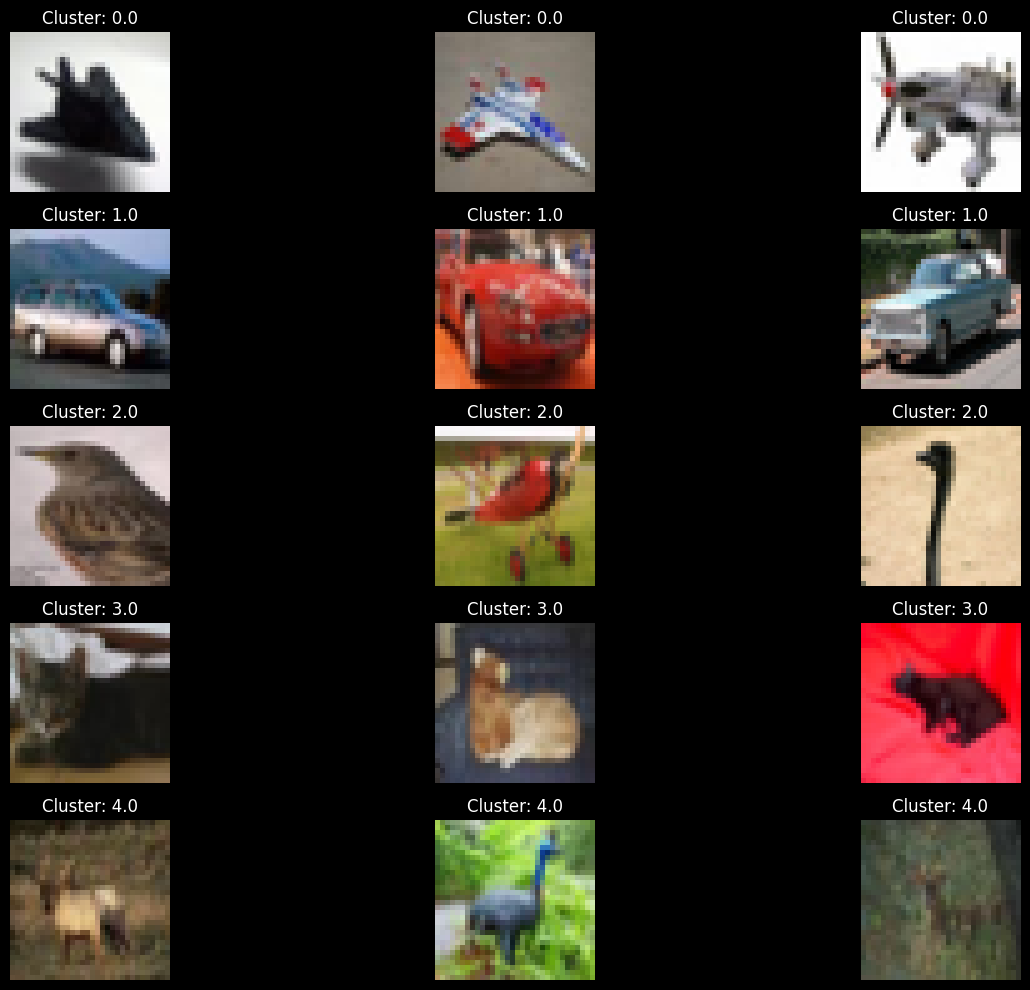

In [10]:
# Visualizar imágenes por clúster
clusters = np.unique(y_train_propagated)
plt.figure(figsize=(15, 10), facecolor='black')  # Fondo negro general

for i, cluster in enumerate(clusters[:5]):
    cluster_indices = np.where(y_train_propagated == cluster)[0][:3]  # Selecciona 3 imágenes por clúster
    for j, idx in enumerate(cluster_indices):
        img, _ = cifar_data[idx]
        img = img.permute(1, 2, 0).numpy()

        ax = plt.subplot(5, 3, i * 3 + j + 1)
        ax.imshow(img)
        ax.set_title(f'Cluster: {cluster}', color='white')
        ax.axis('off')
        ax.set_facecolor('black')

plt.tight_layout()
plt.show()


In [12]:
# Seleccionar imágenes de baja confianza
probas = log_reg.predict_proba(X_train_pca[:1000])
labels_ixs = np.argmax(probas, axis=1)
confidences = np.array([proba[ix] for proba, ix in zip(probas, labels_ixs)])
sorted_ixs = np.argsort(confidences)
lowest_confidence_ixs = sorted_ixs[:k]

# Corregir etiquetas
y_train_corrected = y_train_propagated.copy()
y_train_corrected[lowest_confidence_ixs] = y_train[lowest_confidence_ixs]

# Reentrenar modelo
log_reg_active = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg_active.fit(X_train_pca[:1000], y_train_corrected[:1000])

# Evaluar precisión
accuracy_active = log_reg_active.score(X_test_pca, y_test)
print(f"Precisión después de aprendizaje activo: {accuracy_active:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Precisión después de aprendizaje activo: 0.6589


In [13]:
# Mapear etiquetas
unique_labels = np.unique(y_train_corrected)
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
y_train_mapped = np.array([label_to_idx[label] for label in y_train_corrected])
y_test_mapped = np.array([label_to_idx.get(label, 0) for label in y_test])

# Convertir a tensores
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_mapped, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_mapped, dtype=torch.long).to(device)

# Dataset y DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Definir red neuronal
class SimpleNN(nn.Module):
    def __init__(self, input_dim, n_classes):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, n_classes)
        )
    def forward(self, x):
        return self.fc(x)

# Instanciar modelo
model = SimpleNN(X_train_pca.shape[1], len(unique_labels)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento
epochs = 3
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluación
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in zip(X_test_tensor.split(64), y_test_tensor.split(64)):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
print(f"Precisión red neuronal (etiquetas corregidas): {correct/total:.4f}")

Epoch 1/3, Loss: 0.3616
Epoch 2/3, Loss: 0.1274
Epoch 3/3, Loss: 0.0704
Precisión red neuronal (etiquetas corregidas): 0.6814
